<a href="https://colab.research.google.com/github/georgef3/Visuals/blob/main/ACLED_Afghanistan_%2B_Strip_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Afghanistan Conflict Data Exploration

---



## Data Ingest

In [ ]:
import pandas as pd

#Read in the appropriate file

initial_df = pd.read_excel('CCA_2017-2020_Mar21.xlsx')

initial_df.columns

Index(['ISO', 'EVENT_ID_CNTY', 'EVENT_ID_NO_CNTY', 'EVENT_DATE', 'YEAR',
       'TIME_PRECISION', 'EVENT_TYPE', 'SUB_EVENT_TYPE', 'ACTOR1',
       'ASSOC_ACTOR_1', 'INTER1', 'ACTOR2', 'ASSOC_ACTOR_2', 'INTER2',
       'INTERACTION', 'REGION', 'COUNTRY', 'ADMIN1', 'ADMIN2', 'ADMIN3',
       'LOCATION', 'LATITUDE', 'LONGITUDE', 'GEO_PRECISION', 'SOURCE',
       'SOURCE_SCALE', 'NOTES', 'FATALITIES', 'TIMESTAMP'],
      dtype='object')

In [ ]:
#1. Connect to Google Sheets worksheet
import pandas as pd
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)
workbook = 'https://docs.google.com/spreadsheets/d/1v4aJaklIzZE8GSxzhEWXYPudR8HbRTNSGD3P93NFyls/edit?pli=1#gid=1430895484'

#Format worksheet into dataframe
wb = gc.open_by_url(workbook)
sheet = wb.worksheet('Sheet1')
gdata = sheet.get_all_values()
gdf = pd.DataFrame(gdata)
gdf.columns = gdf.iloc[0]
gdf = gdf.iloc[1:]
gdf['FATALITIES'] = gdf['FATALITIES'].apply(pd.to_numeric, errors='coerce')
gdf['LATITUDE'] = gdf['LATITUDE'].apply(pd.to_numeric, errors='coerce')
gdf['LONGITUDE'] = gdf['LONGITUDE'].apply(pd.to_numeric, errors='coerce')
gdf['EVENT_DATE'] = gdf['EVENT_DATE'].apply(pd.to_datetime, errors = 'coerce')
initial_df = gdf

In [ ]:
initial_df['COUNTRY'].unique()
initial_df.head(2)

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,...,ADMIN3,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TIMESTAMP
1,4,AFG24,24,2017-01-01,2017,2,Violence against civilians,Attack,Taliban,,...,,Nawa-e Barakzayi,31.392,64.319,2,Pajhwok Afghan News; Khaama Press,National,Reported 5 Jan 2017: Taliban killed a female p...,1,1580847062
2,4,AFG20,20,2017-01-01,2017,1,Explosions/Remote violence,Remote explosive/landmine/IED,Unidentified Armed Group (Afghanistan),,...,,Herat,34.348,62.200,1,Herat TV; Aina TV; TOLO News; Khaama Press; Af...,Subnational-National,"Jan 1, 2017: A bomb in a Shi'a mosque in Bagh ...",1,1580847062


In [ ]:
df = initial_df

#Filter Dataframe to Afghanistan
df = df[df.COUNTRY == 'Afghanistan']

Taliban_Filter = [item for item in df.ACTOR1.unique() if 'Taliban' in item]

df = df[df.ACTOR1.isin(Taliban_Filter)]

df = df[df.FATALITIES > 0]

df.head(1)

#df = df.head(50)

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,...,ADMIN3,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TIMESTAMP
1,4,AFG24,24,2017-01-01,2017,2,Violence against civilians,Attack,Taliban,,...,,Nawa-e Barakzayi,31.392,64.319,2,Pajhwok Afghan News; Khaama Press,National,Reported 5 Jan 2017: Taliban killed a female p...,1,1580847062


### Circle Map Experimentation

In [ ]:
#plot the different types of events over time with seaborn or pandas
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium import plugins
from folium import FeatureGroup, LayerControl, Map, Marker

lat_lst = df['LATITUDE'] #create a list of latitudes, longitudes and other items to incorporate in the map
lng_lst = df['LONGITUDE']
lat_start = df['LATITUDE'].mean() #center the graph on a specific location
long_start = df['LONGITUDE'].mean()
fatalities_lst = df['FATALITIES']
actor_lst = df['ACTOR1']
test_lst = df['EVENT_TYPE']

Test_feature_group = folium.FeatureGroup("Circles") #Create a featuregroup

for test, lat, lng, actor, fatal in zip(test_lst, lat_lst, lng_lst, actor_lst, fatalities_lst):
    if test != '':            #filtered by the event type
        Test_feature_group.add_child(
            folium.CircleMarker(location=[lat,lng],           #create circlemarkers for each
                          popup = None,
                          radius = fatal, fill = True,
                          tooltip=('<font face="verdana">'+ '<b>Fatalities: </b>' + str(fatal)),
                          attr='Global Engagement Center - CT Team & Analytics and Research Team'))
    else:
        continue

#Create the Map
n = folium.Map(location= [lat_start,long_start], tiles = 'stamen terrain', zoom_start= 7, min_zoom = 3)

Test_feature_group.add_to(n)

#Full screen toggle
plugins.Fullscreen(
    position='bottomright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True).add_to(n)

n.add_child(folium.LayerControl())

#Save the file
n.save('Circle Map.html')

# Ordinary Heat Map

In [ ]:
from folium.plugins import HeatMap, Search

feature_group_Heat = folium.FeatureGroup("Heat")

heat_data = [[row['LATITUDE'],row['LONGITUDE']] for index, row in df.iterrows()]

HeatMap(heat_data).add_to(feature_group_Heat)

from folium import FeatureGroup, LayerControl, Map, Marker, CircleMarker

m = folium.Map([lat_start, long_start], tiles='stamen terrain', zoom_start=6)


m.add_child(feature_group_Heat)
m.add_child(folium.LayerControl())


m.save('Ordinary Heat Map.html')

# Heat Map Over Time

In [ ]:
from folium import FeatureGroup, LayerControl, Map, Marker, CircleMarker
import datetime as dt
from folium.plugins import MiniMap

#Create Dots from the Dataframe to be hovered over
feature_group_dots = FeatureGroup("Taliban Activity w/ Fatalities")

for lat,lon,fatal,date in zip(df['LATITUDE'],df['LONGITUDE'], df['FATALITIES'], df.EVENT_DATE):
     folium.CircleMarker([lat, lon],
                            popup=None,
                            radius=1,
                            color = '#8D98AA',
                            tooltip = ('<font face="verdana">'+ '<b>Fatalities: </b>' + str(fatal) +'<br>'
                                       +'<b> Date: </b>' + str(date)[0:10] + '<br>')).add_to(feature_group_dots)

#Map the violence over day of the month
#create event day column
df['day'] = df['EVENT_DATE'].apply(lambda x: x.day)
df['month'] = df['EVENT_DATE'].apply(lambda x: x.month)
df['quarter'] = df['EVENT_DATE'].apply(lambda x: x.quarter)

#Add minimap
minimap = plugins.MiniMap(tiles = 'stamentoner')

#Create index for labeling
index = ['January','February','March','April','May','June','July','August','September','October','November','December']


df_day_list = []
for day in df.day.sort_values().unique():
    df_day_list.append(df.loc[df.day == day, ['LATITUDE', 'LONGITUDE', 'FATALITIES']].groupby(['LATITUDE', 'LONGITUDE']).sum().reset_index().values.tolist())

df_month_list = []
for month in df.month.sort_values().unique():
    df_month_list.append(df.loc[df.month == month, ['LATITUDE', 'LONGITUDE', 'FATALITIES']].groupby(['LATITUDE', 'LONGITUDE']).sum().reset_index().values.tolist())


t = folium.Map([lat_start, long_start], tiles='stamen terrain', zoom_start=7, attr='Test')

from folium.plugins import HeatMapWithTime

t.add_child(HeatMapWithTime(df_month_list, index = index, name = 'Heat Map Over Time', auto_play=True))
t.add_child(feature_group_dots)
t.add_child(minimap)
t.add_child(folium.LayerControl())

t.save('Taliban Attacks Over Time Map.html')


<ipython-input-23-ec2a8c31c3bb>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


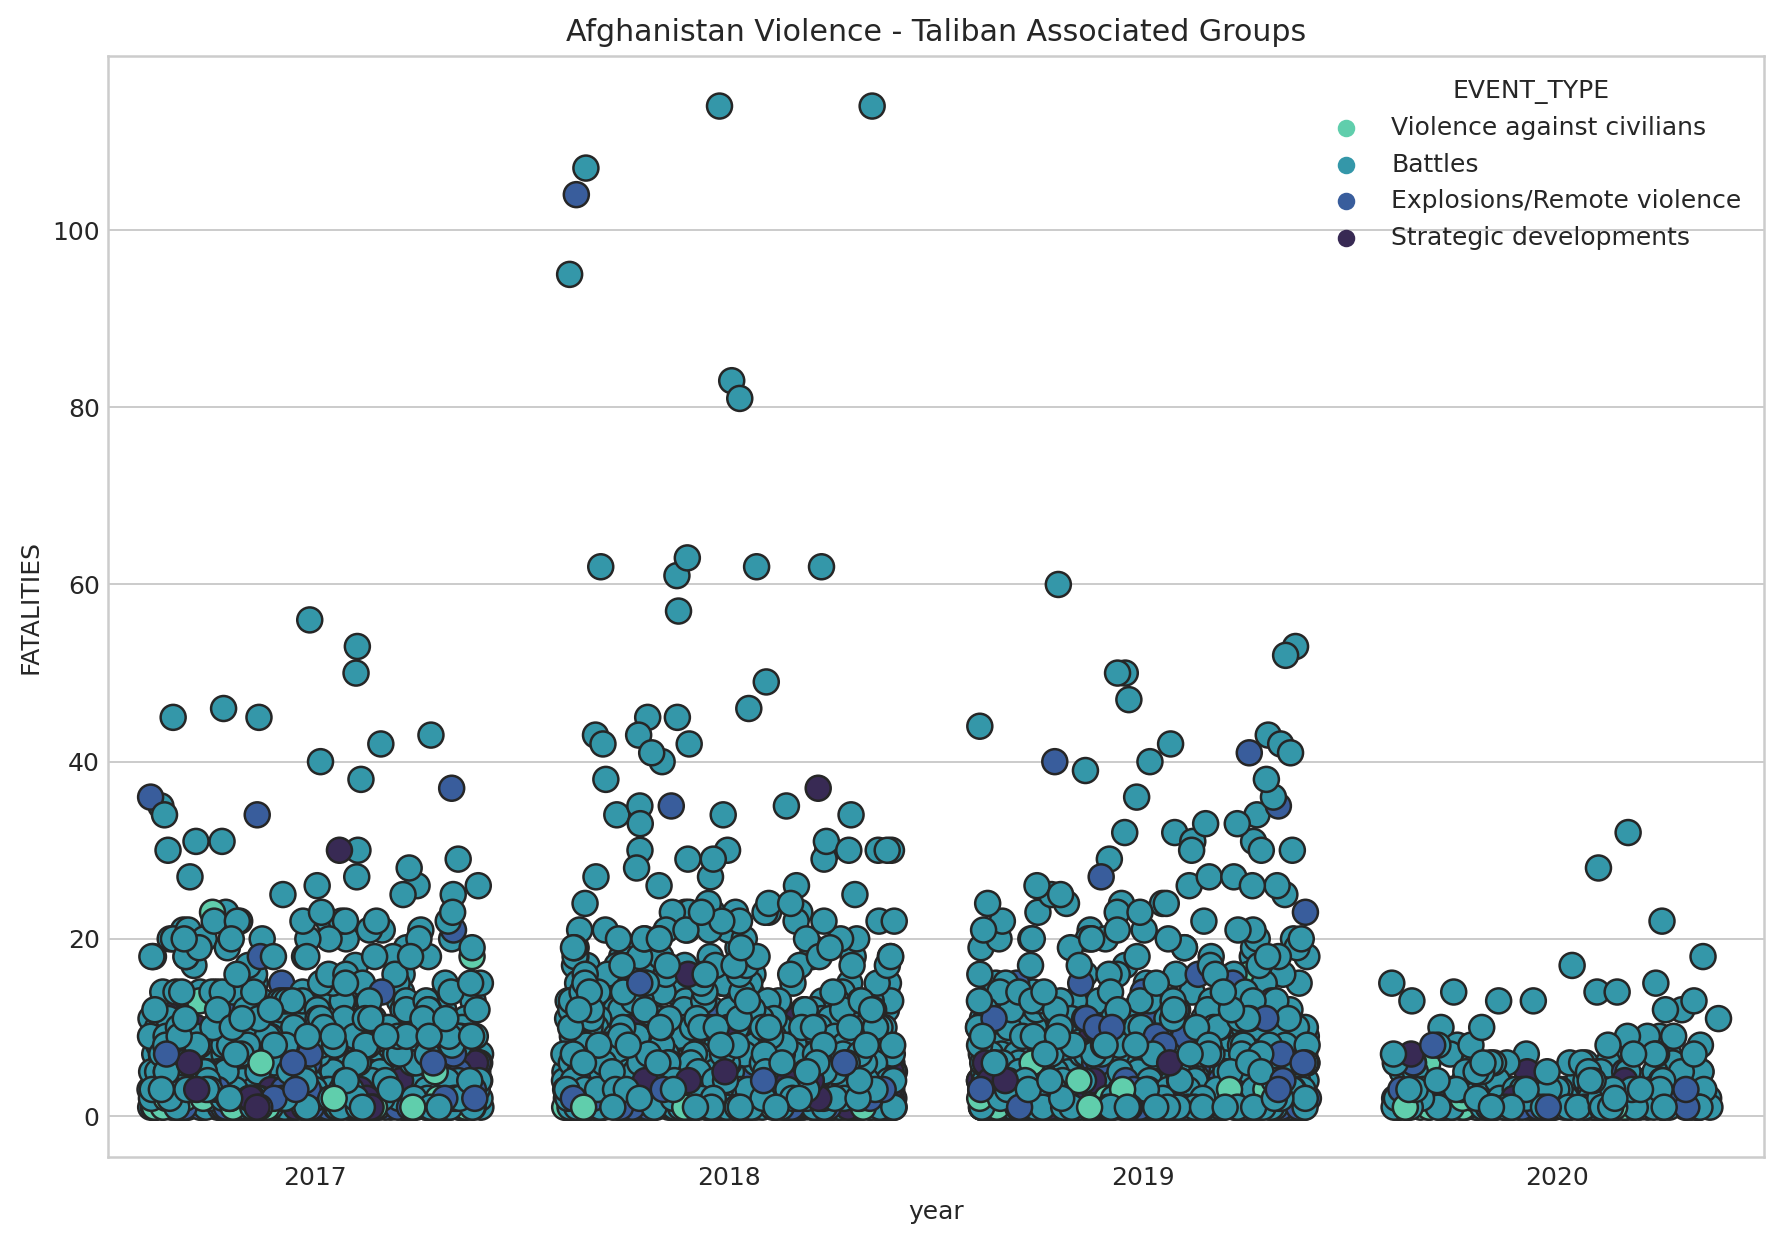

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#create event day column
df['year'] = df['EVENT_DATE'].apply(lambda x: x.year)

plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "verdana"
plt.figure(figsize=(10,7), dpi = 180)
ax = sns.stripplot(x=df['year'], y = df['FATALITIES'],hue = df['EVENT_TYPE'], size=10, linewidth=1, jitter=0.4, palette = 'mako_r')

# Decorations
plt.title('Afghanistan Violence - Taliban Associated Groups', fontsize=12)
plt.tight_layout()
plt.show()
